<a href="https://colab.research.google.com/github/umar052001/Deep-Learning-with-Tensorflow/blob/master/04_transfer_learning_in_tensorflow_01_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow 01: Feature Extraction

Transfer learning is leveraging a working model's architechture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architechture proven to work on similar problem as our own.
2. Neural Network architechture which has already learned patterns on similar data as ours, then we can adapt those patterns to our own data.

In [4]:
!nvidia-smi

Tue Sep  6 22:26:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [5]:
# Get 10% of data from Food101 (10 food classes)
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-09-06 22:26:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  53.2MB/s    in 3.0s    

2022-09-06 22:26:39 (53.2 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [6]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' ")

There are 2 directories and 0 images in '10_food_classes_10_percent' 
There are 10 directories and 0 images in '10_food_classes_10_percent/test' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak' 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## Creating data loaders (preparing the data)
We'll use `ImageDataGenerators` to load in our images in batches

In [28]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.,)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:
* Tracking experiments with tensorboard callback
* Model Checkpoint with ModelCheckpoint callback
* Stopping a model (before it trains too long and overfits) with EarlyStopping callback.

In [29]:
# Create tensorboard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name +"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using tensorflow hub
In the past we've been creating our models from scratch.

Now majority of our model's layers are going to come from tensorflow hub

We can access pretrianed models on: http://tfhub.dev

Browsing the tensorflow hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [30]:
# Let's compare the following two model
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [31]:
# Import dependencies
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers

In [32]:
# Let's make a create model function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow hub url and creates a keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow hub feature extraction URL.
    num_class (int): Number of output neurons in output layers should be equal to
                    number of target classes. Default 10.
  Return:
    An uncompiled Keras Sequential model with model url as feature extractor layer
    and Dense output layer with num_classes output neuron
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extraction_layer = hub.KerasLayer(model_url, 
                                           trainable=False,# freeze already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

### Creating resnet Tensorflow hub feature extraction model

In [33]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [34]:
# Compile resnet model  
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [35]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving tensorboard log files to: tensorflow_hub/resnet50V2/20220907-000207
Epoch 1/5
24/24 [==============================] - 20s 725ms/step - loss: 2.0331 - accuracy: 0.3267 - val_loss: 1.2181 - val_accuracy: 0.6124
Epoch 2/5
24/24 [==============================] - 16s 678ms/step - loss: 0.9206 - accuracy: 0.7253 - val_loss: 0.8590 - val_accuracy: 0.7228
Epoch 3/5
24/24 [==============================] - 16s 673ms/step - loss: 0.6297 - accuracy: 0.8187 - val_loss: 0.7517 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 16s 666ms/step - loss: 0.4872 - accuracy: 0.8707 - val_loss: 0.6963 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 16s 669ms/step - loss: 0.3860 - accuracy: 0.9053 - val_loss: 0.6670 - val_accuracy: 0.7812


There are some incredible results in front of us when we used transfer learning.
Our transfer learninng features extractor out performed ALL of the previous models we built by hand...(substantially) and in a quicker time AND with only 10% of of the training examples.

In [24]:
# Lets create a function to plot loss curve
import matplotlib.pyplot as plt
def plot_loss_curve(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history:Tensorflow history object.
  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

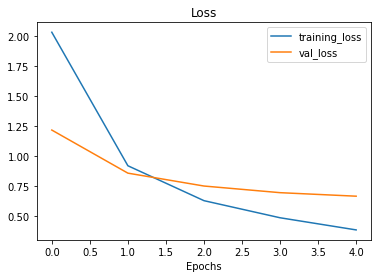

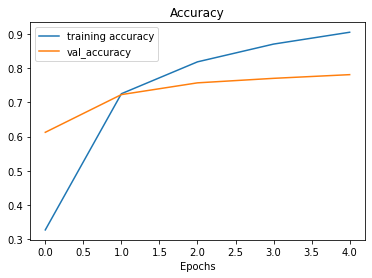

In [36]:
plot_loss_curve(resnet_history)

 ### Creating Efficientnet Tensorflow hub feature extraction model

In [39]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit efficientnet to 10% of our data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              steps_per_epoch=len(train_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving tensorboard log files to: tensorflow_hub/efficientnetb0/20220907-001500
Epoch 1/5
24/24 [==============================] - 26s 709ms/step - loss: 1.8148 - accuracy: 0.4480 - val_loss: 1.2796 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 16s 692ms/step - loss: 1.0388 - accuracy: 0.7867 - val_loss: 0.8640 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 16s 671ms/step - loss: 0.7447 - accuracy: 0.8533 - val_loss: 0.6954 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 16s 688ms/step - loss: 0.5976 - accuracy: 0.8747 - val_loss: 0.6051 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 15s 641ms/step - loss: 0.5061 - accuracy: 0.8987 - val_loss: 0.5515 - val_accuracy: 0.8612


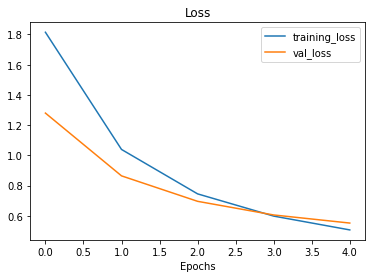

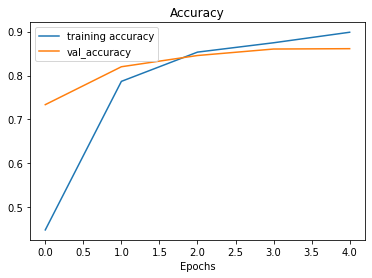

In [40]:
plot_loss_curve(efficientnet_history)

In [41]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [42]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning
* **"As is"** transfer learning - using an existing model with no changes whatsoever (eg using imagenet model on 100 ImageNet classes, none of your own)
* **"Features extraction"** transfer learning - use the prelearned patterns of an existing model (eg EfficientnetB0 trained on ImageNet) and adjust the output layer on your own (1000 classes -> 10 classes of food)
* **"Fine tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all the underlaying layers (including new output layers) 

In [47]:
# How many layers does our feature extractor efficientnetb0 have?
len(efficientnet_model.layers[0].weights)

309

## Comparing our model's results using TensorBoard

> When you upload things to tensorboard.dev, your experiments are public.

In [ ]:
# Upload TensorBoard dev logs
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different tf hub feature extraction model architechtures using 10% of the training data" \
  --one_shot  

Our tensorboard experiments are uploaded publiclly here https://tensorboard.dev/experiment/FWgOPYwYT96QBHONzC92sw/

In [50]:
!tensorboard dev list

https://tensorboard.dev/experiment/FWgOPYwYT96QBHONzC92sw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different tf hub feature extraction model architechtures using 10% of the training data
	Id                   FWgOPYwYT96QBHONzC92sw
	Created              2022-09-07 00:46:37 (7 minutes ago)
	Updated              2022-09-07 00:46:46 (7 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  12681087
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# ! tensorboard dev delete --experiment_id [paste the id here]